In [0]:
import pandas as pd

In [4]:
data_raw = pd.read_csv("data/movies_metadata.csv")

# only keep the needed columns
data = data_raw[["overview","title","genres"]]
data = data[~data['overview'].isna()]

# create a mask indication where a genre value exists
has_genres_mask = data['genres'] != "[]"
genres = data['genres'][has_genres_mask]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


AST allows us to evaluate the string list in each genre entry, basically creates a list from a string with list content.

In [ ]:
import ast

def make_labels(strings):
    evaluated_string = ast.literal_eval(strings)
    return [g['name'] for g in evaluated_string]

genres_list = genres.apply(make_labels)

The MultiLabelBinarizer was used as it gives a simple and fast way of finding all the classes in a column.

Many of the classes where removed from the overall class list, as they had a small count.
For example 
```
['Aniplex', 'BROSTA TV', 'Carousel Productions']
```
All had one occurence each.

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
"""
the MultiLabelBinarizer simply looks through all entries in a list and creates list containing unique labels.
"""
labeler = MultiLabelBinarizer()
labeler.fit(genres_list)

full_labels = labeler.transform(genres_list)
"""
Remove all the redundant classes, some of the genres contain one entry.
"""
top = sorted(list(zip(full_labels.sum(axis=0), labeler.classes_)))[::-1]
top_genres = sorted([t[1] for t in top][1:10])

top_labeler = MultiLabelBinarizer(classes=top_genres)
top_labeler.fit(genres_list)

print(top_labeler.classes_)
"""
now we have a binary list representing the genres.
this can be used directly in the training
"""
y = top_labeler.transform(genres_list)

"""
Check if the sum of all entries is zero
"""
no_labels_mask = y.sum(axis=1)==0

['Action' 'Adventure' 'Comedy' 'Crime' 'Documentary' 'Horror' 'Romance'
 'Science Fiction' 'Thriller']


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['Animation', 'Aniplex', 'BROSTA TV', 'Carousel Productions', 'Drama', 'Family', 'Fantasy', 'Foreign', 'GoHands', 'History', 'Mardock Scramble Production Committee', 'Music', 'Mystery', 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'Sentai Filmworks', 'TV Movie', 'Telescene Film Group Productions', 'The Cartel', 'Vision View Entertainment', 'War', 'Western'] will be ignored
  .format(sorted(unknown, key=str)))


Since we removed many classes from the dataset, the input data needs to reflect this change, by not having any empty classes.
This is done by removing all the already empty classes, then removing all sets after class reduction.

In [0]:
pre_1_X1 = data['title'][has_genres_mask].astype(dtype="str")
pre_1_X2 = data['overview'][has_genres_mask].astype(dtype="str")

pre_X1 = pre_1_X1[~no_labels_mask]
pre_X2 = pre_1_X2[~no_labels_mask]
y = y[~no_labels_mask]

In [8]:
"""
Just checking the size of all entries, Now we are sure everything is aligned correctly
"""
print(len(y))
print(len(pre_X1))
print(len(pre_X2))

33772
33772
33772


In [0]:
from tensorflow import keras
import tensorflow as tf

In [0]:
# The maximum number of words to be used.
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100 # This is a fixed value, in this case
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(pre_X1 + pre_X2)
word_index = tokenizer.word_index

In [11]:
from joblib import dump

dump(top_labeler, "model/class_labeler.joblib")
dump(tokenizer, "model/tokenizer.joblib")

['model/tokenizer.joblib']

In [0]:
import numpy as np
def max_len(array_):
    max_l = 0
    for x in array_:
        if len(x) > max_l:
            max_l = len(x)
    return max_l
X1 = tokenizer.texts_to_sequences(pre_X1)
X2 = tokenizer.texts_to_sequences(pre_X2)

X1_max_len = max_len(X1)
X2_max_len = max_len(X2)

X1 = keras.preprocessing.sequence.pad_sequences(X1, maxlen=X1_max_len)
X2 = keras.preprocessing.sequence.pad_sequences(X2, maxlen=X2_max_len)

This section attempted to split the data into training and validation sets.

However, this was scrapped in favor of letting the fit function deal with the validation split.

In [13]:
# from sklearn.model_selection import train_test_split
# 
# X1_train, X1_test = train_test_split(X1, shuffle = False)
# X2_train, X2_test = train_test_split(X2, shuffle = False)
# Y_train, Y_test = train_test_split(y, shuffle = False)

# print(X1_train.shape,Y_train.shape)
# print(X1_test.shape,Y_test.shape)

'\nthis section attempted to split the data into training and validation sets\nHowever, this was scrapped in favor of letting the fit function\ndeal with the validation split\n'

In [14]:
"""
load the classifier we constructed
"""
from model import GenreClassifier

model = GenreClassifier(len(top_labeler.classes_), MAX_NB_WORDS, X1_max_len, X2_max_len)

W0704 23:09:33.509284 140357921113984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 23:09:33.526669 140357921113984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 23:09:33.529930 140357921113984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 23:09:33.549435 140357921113984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0704 23:09:33.558836 

Train the classifier

The specified batch size requires lots of memory, consider reducing the value on first run.

The model checkpoint is setup in a way to only save models when the valuation accuracy has increased. 
The valuation accuracy is used as opposed to the training accuracy as it reflects true generalization on the data, rather than "memorized" entries.


In [15]:

#%%
from keras.callbacks import ModelCheckpoint

filepath="model/weights-epoch-{epoch:02d}-val-acc-{val_acc:.3f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#%%
EPOCHS = 60
BATCH_SIZE = 2048
history = model.model.fit([X1, X2], y,
                    validation_split=0.2,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    callbacks=callbacks_list)

W0704 23:09:35.518960 140357921113984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 27017 samples, validate on 6755 samples
Epoch 1/60
27017/27017 [==============================] - 20s 729us/step - loss: 3.2770 - acc: 0.2800 - val_loss: 7.9840 - val_acc: 0.3281
Epoch 2/60
27017/27017 [==============================] - 15s 562us/step - loss: 2.6124 - acc: 0.4329 - val_loss: 12.6696 - val_acc: 0.3281
Epoch 3/60
27017/27017 [==============================] - 15s 568us/step - loss: 2.3628 - acc: 0.5071 - val_loss: 11.9694 - val_acc: 0.1557
Epoch 4/60
27017/27017 [==============================] - 16s 574us/step - loss: 2.0394 - acc: 0.5579 - val_loss: 11.9809 - val_acc: 0.1563
Epoch 5/60
27017/27017 [==============================] - 15s 570us/step - loss: 1.8182 - acc: 0.5966 - val_loss: 12.1584 - val_acc: 0.1893
Epoch 6/60
27017/27017 [==============================] - 15s 568us/step - loss: 1.6659 - acc: 0.6249 - val_loss: 11.5536 - val_acc: 0.1590
Epoch 7/60
27017/27017 [==============================] - 15s 565us/step - loss: 1.5412 - acc: 0.6437 - val_loss

In [0]:
import matplotlib.pyplot as plt

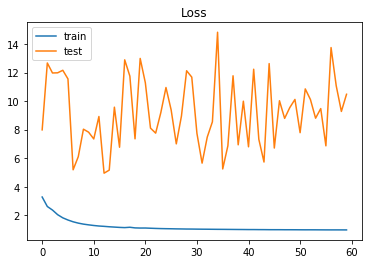

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

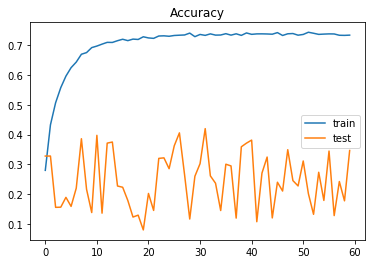

In [18]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [0]:
predictions = model.model.predict([X1, X2], batch_size=2048)

The confusion matrix below allows us to see how the predictions compare to the ground truth,
the labels from x-axis are omitted from this plot to avoid clutter.

Although not prominent or complete there is a distinct diagonal line indicating some degree of recall in the classifier. The classifier seems to have a bias towards the crime class this can be due the multi label property of each input, our classifier only assesses single. Thus, the crime bias might occur as it would occur as a supplementary genre alongside another genre.

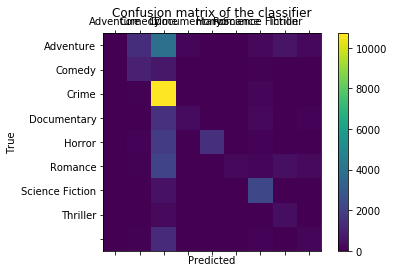

In [20]:
"""
The confusion matrix below allows us to see how the predictions compare to the ground truth,
the labels from x-axis are omitted from this plot to avoid clutter.
"""
from sklearn import metrics
import matplotlib.pyplot as plt

matrix = metrics.confusion_matrix(y.argmax(axis=1), predictions.argmax(axis=1))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + top_labeler.classes_)
ax.set_yticklabels([''] + top_labeler.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()